# 1. <a id='toc1_'></a>[Прогнозирование оттока клиентов в сети отелей «Как в гостях»](#toc0_)

`Описание проекта` - цель данного проекта: выявить потенциальных постояльцев отеля которые с большой долей вероятности отменят бронирование гостиничного номера. Данное исследование поможет улучшить планирование расходов бизнеса и минимизировать финансовые издержки для отеля.

**Содержание**<a id='toc0_'></a>    
- 1. [Прогнозирование оттока клиентов в сети отелей «Как в гостях»](#toc1_)    
    - 1.1.1. [Шаг 1. Откройте файлы с данными](#toc1_1_1_)    
    - 1.1.2. [Шаг 2. Предобработка и исследовательский анализ данных](#toc1_1_2_)    
      - 1.1.2.1. [Предобработка данных](#toc1_1_2_1_)    
    - 1.1.3. [Исследовательский анализ данных](#toc1_1_3_)    
    - 1.1.4. [Шаг 3. Формулировка ML-задачи на основе бизнес-задачи](#toc1_1_4_)    
    - 1.1.5. [Шаг 4. Разработка модели ML](#toc1_1_5_)    
      - 1.1.5.1. [Применение лучшей модели на тестовой выборке](#toc1_1_5_1_)    
    - 1.1.6. [Шаг 5. Опишите портрет «ненадёжного» клиента](#toc1_1_6_)    
    - 1.1.7. [Шаг 6. Напишите общий вывод](#toc1_1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### 1.1.1. <a id='toc1_1_1_'></a>[Шаг 1. Откройте файлы с данными](#toc0_)

Импортируем необходимые модули и библиотеки согласно `PEP-8`

In [1]:
# стандартные библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# сторонние библиотеки
from sklearn import datasets
from sklearn import svm
from scipy.stats import uniform
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Блок с константами

In [2]:
# бюджет выделенный на разработку модели
BUDGET = 400000

Загружаем данные

In [3]:
try:
    df_train = pd.read_csv('hotel_train.csv')
    df_test = pd.read_csv('hotel_test.csv')
except:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')

Проводим предворительное ознакомление с данными

Выводим основную информацию для каждой таблицы.
Для оптимизации кода создаём функцию `show_i()` принимающую как аргумент датафрейм и выводящую на экран необходимую информацию.

In [4]:
def show_i(data):

    '''Выводим на экран следущую информацию:

    - размер таблицы
    - основную информацию
    - первые 5 строк таблицы
    - суммарная статистика по числовым параметрам
    - суммарная статистика по нечисловым параметрам'''

    display(data.shape)
    display(data.info())
    display(data.head())
    display(data.describe())
    display(data.describe(include=['O']))
   

Применяем функцию для ознакомления с данными

In [5]:
show_i(df_train)

(65229, 25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
count,65229,65229,65229,65229,65229,65229
unique,12,5,155,4,7,4
top,October,BB,PRT,TA/TO,A,Transient
freq,9255,51697,28831,54454,50501,45493


In [6]:
show_i(df_test)

(32412, 25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
count,32412,32412,32412,32412,32412,32412
unique,8,5,143,4,7,4
top,May,BB,PRT,TA/TO,A,Transient
freq,5262,24684,9887,27083,23471,27461


`Вывод:` - Тренировочный датасет в два раза больше тестового, это положительно скажется на обучении, много материала.

Предварительное ознакомление не выявило пропущенных значений, но есть признаки которые, возможно, нуждаются в смене типа.
Например: 'lead_time', 'adults', 'children' и 'babies'. Эти значения могут быть переведены из вещественных в цельночисловые (float -> int).

### 1.1.2. <a id='toc1_1_2_'></a>[Шаг 2. Предобработка и исследовательский анализ данных](#toc0_)

#### 1.1.2.1. <a id='toc1_1_2_1_'></a>[Предобработка данных](#toc0_)

Проверим типы данных

In [7]:
# выборка train
print(df_train.dtypes)

# выводим все колонки без пропусков для лучшего обзора
pd.set_option('display.max_columns', None)
df_train.head()

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [8]:
# выборка test
print(df_test.dtypes)
df_test.head()

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


В обоих датафреймах есть признаки описывающие цельные значения, например, количество детей, но их тип указан как вещественный.
Переведём вещественные признаки в цельночисловые.

In [9]:
# меняем тип float -> int в df_train
df_train['lead_time'] = df_train['lead_time'].astype(int)
df_train['adults'] = df_train['adults'].astype(int)
df_train['children'] = df_train['children'].astype(int)
df_train['babies'] = df_train['babies'].astype(int)

# меняем тип float -> int в df_test
df_test['lead_time'] = df_test['lead_time'].astype(int)
df_test['adults'] = df_test['adults'].astype(int)
df_test['children'] = df_test['children'].astype(int)
df_test['babies'] = df_test['babies'].astype(int)

Проверяем что типы поменялись на Int

In [10]:
print(df_train.dtypes)

id                                 int64
is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

In [11]:
print(df_test.dtypes)

id                                 int64
is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

`Вывод:` - типы данных успешно изменены.

Проверяем пропущенные значения в таблицах в процентах

In [12]:
# df_train пропуски
display('df_train missing data:', pd.DataFrame(round(df_train.isna().mean()*100)).style.background_gradient('coolwarm'))

# df_test пропуски
display('df_test missing data:', pd.DataFrame(round(df_test.isna().mean()*100)).style.background_gradient('coolwarm'))

'df_train missing data:'

,0
id,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


'df_test missing data:'

,0
id,0.000000
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
arrival_date_week_number,0.000000
arrival_date_day_of_month,0.000000
stays_in_weekend_nights,0.000000
stays_in_week_nights,0.000000
adults,0.000000


`Вывод:` - пропущенных значений нет.

Проеверяем наличие явных дубликатов

In [13]:
# Проверяем очевидные дубликаты - строки которые полностью повторяют уже встречавшиеся в датасете. Очевидных дубликатов нет.

# df_train дубликаты
print('df_train дубликаты:', df_train.duplicated().sum())

# df_test дубликаты
print('df_test дубликаты:', df_test.duplicated().sum())

df_train дубликаты: 0
df_test дубликаты: 0


`Вывод:` - дубликатов нет

Убраем колонки которые нам не нужны для обучения. Колонка `id` не несёт иформацинной нагрузки, параметр `arrival_date_week_number` также не является информативным, более того, он отчасти дублирует другие временные параметры имеющиеся в нашем распоряжении, например `arrival_date_day_of_month`. Параметр `country` по-сути влияет на параметр `lead_time` тк удалённость страны может влиять на продолжительность времени между бронированием и прибитием в отель.

In [14]:
df_train = df_train.drop(columns=['id', 'arrival_date_week_number', 'country'], axis=1)
df_test = df_test.drop(columns=['id', 'arrival_date_week_number', 'country'], axis=1)

In [15]:
df_train

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,2015,July,1,0,1,1,0,0,BB,Direct,0,0,0,A,0,0,Transient,0,0,1
1,0,14,2015,July,1,0,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,0,0,2015,July,1,0,2,2,0,0,BB,Direct,0,0,0,C,0,0,Transient,0,0,2
3,0,9,2015,July,1,0,2,2,0,0,FB,Direct,0,0,0,C,0,0,Transient,0,1,2
4,1,85,2015,July,1,0,3,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65224,0,23,2016,December,30,2,4,2,0,0,BB,TA/TO,0,0,0,D,0,0,Transient,0,2,6
65225,0,53,2016,December,31,2,3,2,0,0,HB,TA/TO,0,0,0,D,0,0,Transient,0,3,5
65226,0,7,2016,December,31,2,4,2,0,0,BB,TA/TO,0,0,0,D,0,0,Transient,0,1,6
65227,0,17,2016,December,30,2,5,2,0,0,SC,TA/TO,0,0,0,A,0,0,Transient,0,1,7


Проверяем удаление

In [16]:
print(df_train.columns)
print(df_test.columns)

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_nights'],
      dtype='object')
Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of

`Вывод после предобработки` - В результате предобработки были выявлены типы данных нуждающихся в изменении типа, смена типа произведена. Пропусков не найдело, дубликатов - тоже. Были удалены параметры не влияющие на анализ. Данные готовы к анализу. Целевым признаком является `is_canceled`

### 1.1.3. <a id='toc1_1_3_'></a>[Исследовательский анализ данных](#toc0_)

Отфильтруем признаки с небинарными значениям чтобы вывести таблицу с корреляцией.

In [17]:
features1=list(['is_canceled', 'lead_time','arrival_date_month','arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
 'adults', 'children', 'babies', 'meal', 'distribution_channel','reserved_room_type', 'booking_changes', 'days_in_waiting_list', 'customer_type',
 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'])


features2=list(['is_canceled', 'lead_time','arrival_date_month','arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
 'adults', 'children', 'babies', 'meal', 'distribution_channel','reserved_room_type', 'booking_changes', 'days_in_waiting_list', 'customer_type',
  'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'])


Выводим таблицу

In [18]:
df_train[features1].corr()
df_train[features2].corr()

,is_canceled,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.000000,0.328142,-0.001903,-0.013767,0.010650,0.045153,-0.017746,-0.029589,-0.142935,0.075848,-0.186486,-0.257061,0.001542
lead_time,0.328142,1.000000,-0.010252,0.047003,0.172646,0.119617,-0.056359,-0.024649,-0.007191,0.209741,-0.116867,-0.147738,0.157671
arrival_date_day_of_month,-0.001903,-0.010252,1.000000,-0.002017,0.003705,0.006034,0.018558,-0.000482,0.022560,0.017070,0.003816,0.005875,0.001898
stays_in_weekend_nights,-0.013767,0.047003,-0.002017,1.000000,0.197410,0.116679,0.026224,0.018822,0.023118,-0.065167,-0.015870,0.083682,0.644935
stays_in_week_nights,0.010650,0.172646,0.003705,0.197410,1.000000,0.119901,0.023590,0.018428,0.061721,0.036037,-0.026988,0.090359,0.876515
adults,0.045153,0.119617,0.006034,0.116679,0.119901,1.000000,-0.003216,0.019756,-0.056396,-0.013475,0.013321,0.171793,0.150766
children,-0.017746,-0.056359,0.018558,0.026224,0.023590,-0.003216,1.000000,0.018410,0.053835,-0.038615,0.047881,0.112699,0.031268
babies,-0.029589,-0.024649,-0.000482,0.018822,0.018428,0.019756,0.018410,1.000000,0.076910,-0.013391,0.030264,0.098973,0.023608
booking_changes,-0.142935,-0.007191,0.022560,0.023118,0.061721,-0.056396,0.053835,0.076910,1.000000,-0.011225,0.059084,0.043884,0.059468
days_in_waiting_list,0.075848,0.209741,0.017070,-0.065167,0.036037,-0.013475,-0.038615,-0.013391,-0.011225,1.000000,-0.044083,-0.106080,-0.003906


Сохраняем выбранные признаки в переменную для создания графика.

In [19]:
df_train_graph = df_train[features1]

Создаём график с отфильтрованными данными (без бинарных значений кроме целевого) df_train_graph

<AxesSubplot:>

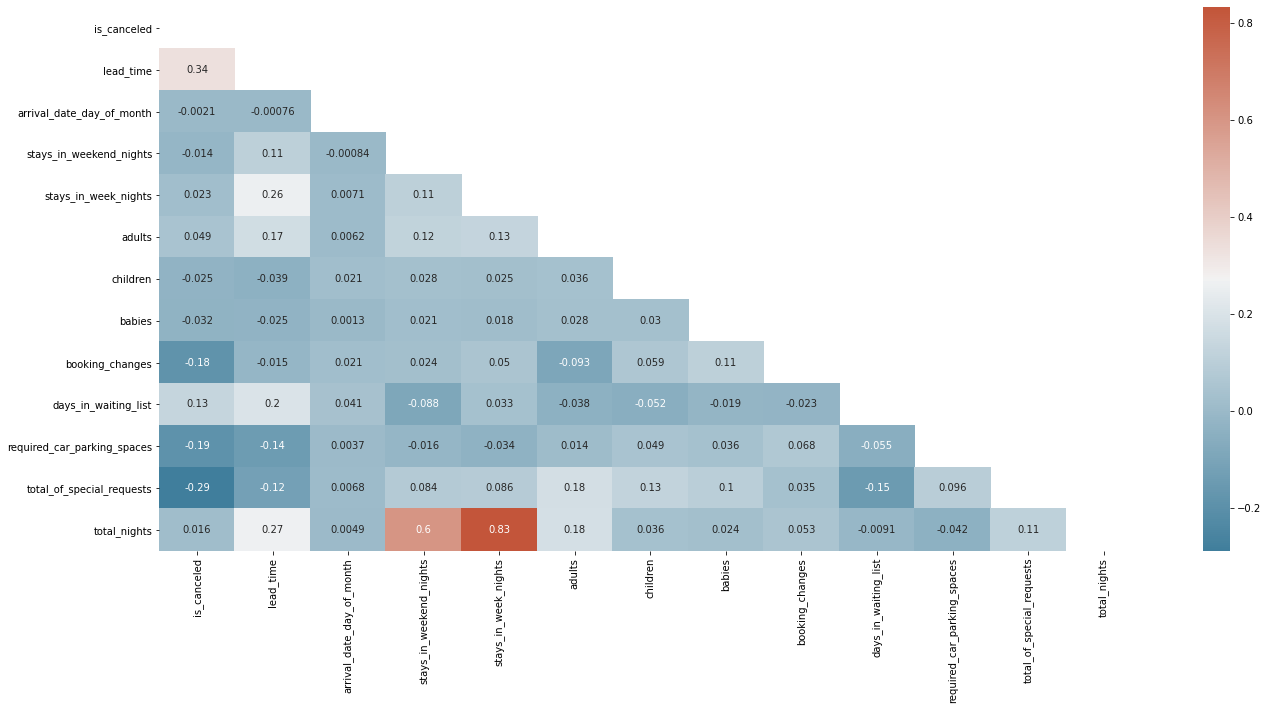

In [20]:
# корреляция по df_train_graph

# корреляция между разными значениями
corr = df_train_graph.corr(method='spearman')

# установка matplotlib plot конфигурации
f, ax = plt.subplots(figsize=(22, 10))

# задаём схему графика
mask = np.triu(np.ones_like(corr, dtype=bool))

# устанавливаем цвет
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# выводим график
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

Проводим ИАД на тренировочных данных. Посмотрим, есть корреляция между значениями в таблице и целевым значением 'is_calceled'

`Вывод:` - мы видим что у целевого признака '`is_canceled`' нет сколько нибудь значимой корреляции с другими параметрами.

Выведем, для ознакомления, значения параметра 'reserved_room_type' для последующего создания новых параметров: 'night_cost' и 'one_time_cleaning'

In [21]:
df_train_unique = df_train.loc[:, 'reserved_room_type']
df_train_unique.unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

Мы видим что типы номеров записаны с пробелами. Учтём при создании новых параметров.

Создаём две функции: `night` где подсчитываем cтоимось ночного проживания в номере в зависимости от категории номера. И `cleaning` где записываем стоимость затран на уборку номера.

In [22]:
# создаём функцию night

def night(row):
    row = row['reserved_room_type']
    if row == 'A               ':
        return 1000
    if row == 'B               ':
        return 800
    if row == 'C               ':
        return 600
    if row == 'D               ':
        return 550
    if row == 'E               ':
        return 500
    if row == 'F               ':
        return 450
    if row == 'G               ':
        return 350

In [23]:
# создаём функцию night cleaning

def cleaning(row):
    row = row['reserved_room_type']
   
    if row == 'A               ':
        return 400
    if row == 'B               ':
        return 350
    if row == 'C               ':
        return 350
    if row == 'D               ':
        return 150
    if row == 'E               ':
        return 150
    if row == 'F               ':
        return 150
    if row == 'G               ':
        return 150


Применяем функции для создания новых колонок со стоимостью номера за ночь и стоимость уборки номера.

In [24]:
# добавляем новые параметры в train
df_train['winter_night_cost'] = df_train.apply(night, axis=1)
df_train['one_time_cleaning_winter'] = df_train.apply(cleaning, axis=1)

# добавляем новые параметры в test
df_test['winter_night_cost'] = df_train.apply(night, axis=1)
df_test['one_time_cleaning_winter'] = df_train.apply(cleaning, axis=1)

Проверяем создание новых параметров и выводим таблицу.

In [25]:
# выводим df_train
display(df_train.head())

# выводим df_test
display(df_test.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter
0,0,7,2015,July,1,0,1,1,0,0,BB,Direct,0,0,0,A,0,0,Transient,0,0,1,1000,400
1,0,14,2015,July,1,0,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1000,400
2,0,0,2015,July,1,0,2,2,0,0,BB,Direct,0,0,0,C,0,0,Transient,0,0,2,600,350
3,0,9,2015,July,1,0,2,2,0,0,FB,Direct,0,0,0,C,0,0,Transient,0,1,2,600,350
4,1,85,2015,July,1,0,3,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter
0,1,74,2017,January,1,1,0,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400
1,1,62,2017,January,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400
2,1,62,2017,January,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,600,350
3,1,71,2017,January,1,2,2,1,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,600,350
4,1,172,2017,January,1,2,5,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400


Учитываем сезонный коэффицент и создаём коэффиценты для последущего расчёта прибыли

In [26]:
def season_coeff(row):
    row = row['arrival_date_month']
    '''для каждого сезона вводим коэффицент нагрузки 
    на который будет умножаться стоимость номера и уборки'''
   
    if row == 'December' or row == 'January' or row == 'February':
        return 1
    if row == 'June' or row == 'July' or row == 'August':
        return 1.4
    else:
        return 1.2


Создаём новые параметры пр помощи функции

In [27]:
df_train['season_coeff'] = df_train.apply(season_coeff, axis=1)
df_test['season_coeff'] = df_test.apply(season_coeff, axis=1)

Выводим датафреймы чтобы убедится что новые признаки добавлены

In [28]:
display(df_train.loc[:, ['arrival_date_month', 'season_coeff']])
display(df_test.loc[:, ['arrival_date_month', 'season_coeff']])

,arrival_date_month,season_coeff
0,July,1.4
1,July,1.4
2,July,1.4
3,July,1.4
4,July,1.4
...,...,...
65224,December,1.0
65225,December,1.0
65226,December,1.0
65227,December,1.0


,arrival_date_month,season_coeff
0,January,1.0
1,January,1.0
2,January,1.0
3,January,1.0
4,January,1.0
...,...,...
32407,August,1.4
32408,August,1.4
32409,August,1.4
32410,August,1.4


Выводим общую гистограмму по всем параметрам df_train

<function matplotlib.pyplot.show(close=None, block=None)>

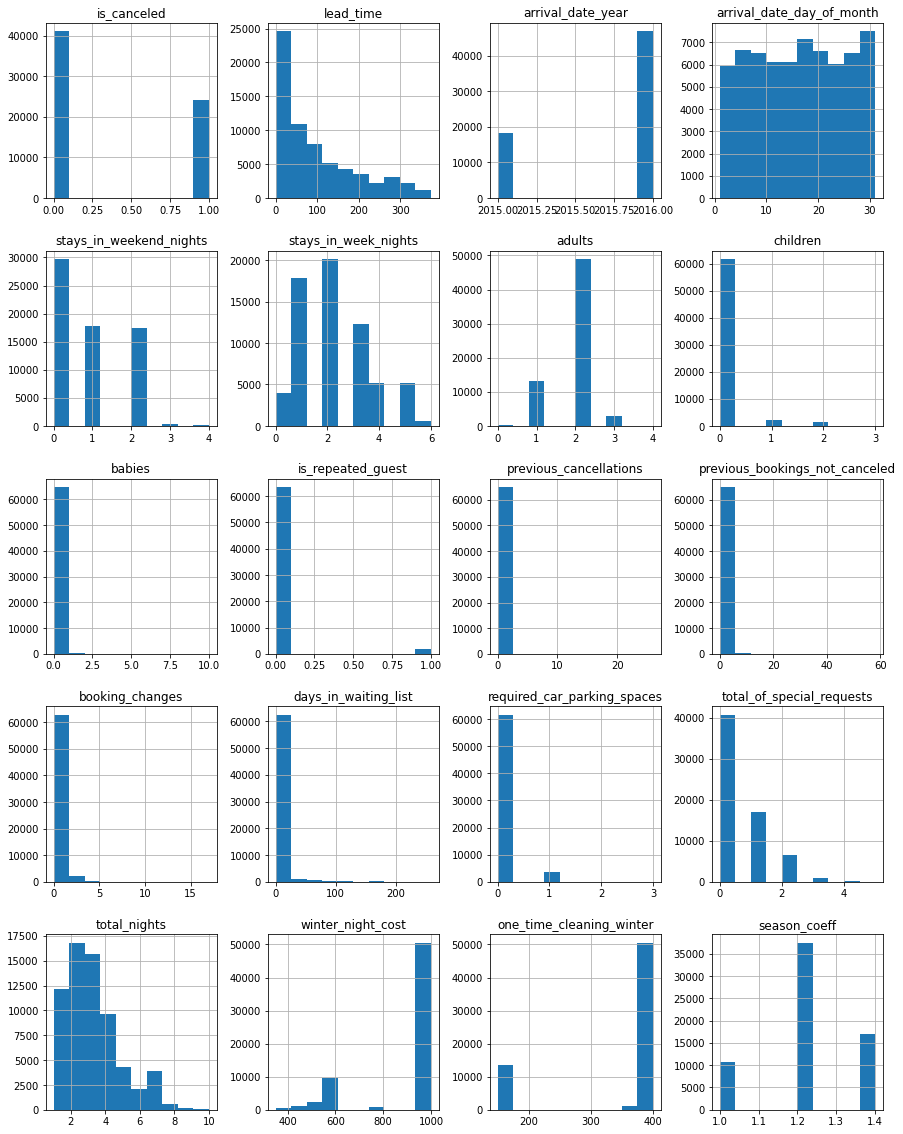

In [29]:
df_train.hist(figsize=(15, 20))
plt.show

Выборочно проверяем некоторые параметры на выбросы.

<AxesSubplot:>

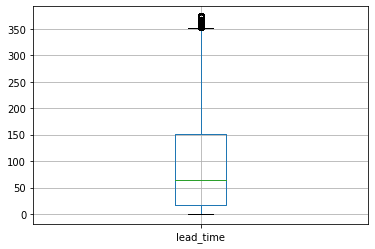

In [30]:
# количество дней между датой бронирования и датой прибытия
df_train.boxplot(column=['lead_time'])


<AxesSubplot:>

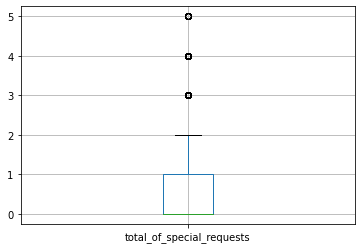

In [31]:
# количество специальных отметок
df_train.boxplot(column=['total_of_special_requests'])

Выборочно проверяем взаимосвязь целевого и некоторых нецелевых параметров

Месяц заезда в гостинницу

Text(0, 0.5, 'Заказы (кол-во)')

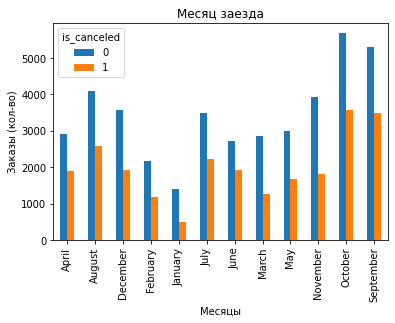

In [32]:
pd.crosstab(df_train['arrival_date_month'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Месяц заезда')
plt.xlabel('Месяцы')
plt.ylabel('Заказы (кол-во)')

День заезда

Text(0, 0.5, 'Заказы (кол-во)')

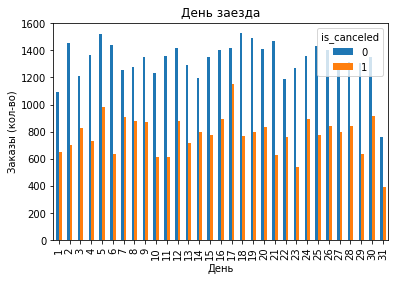

In [33]:
pd.crosstab(df_train['arrival_date_day_of_month'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('День заезда')
plt.xlabel('День')
plt.ylabel('Заказы (кол-во)')

Заказы по годам

Text(0, 0.5, 'Заказы (кол-во)')

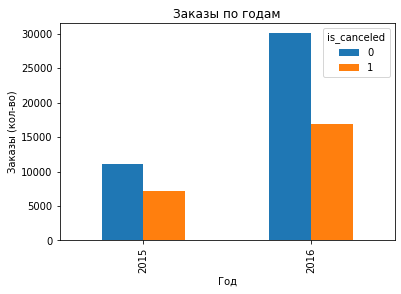

In [34]:
pd.crosstab(df_train['arrival_date_year'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Заказы по годам')
plt.xlabel('Год')
plt.ylabel('Заказы (кол-во)')

Количество младенцев

Text(0, 0.5, 'Заказы (кол-во)')

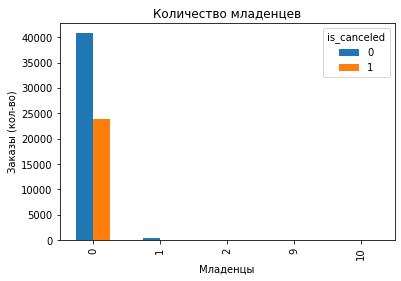

In [35]:
pd.crosstab(df_train['babies'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Количество младенцев')
plt.xlabel('Младенцы')
plt.ylabel('Заказы (кол-во)')


Тип заказчика

Text(0, 0.5, 'Заказы (кол-во)')

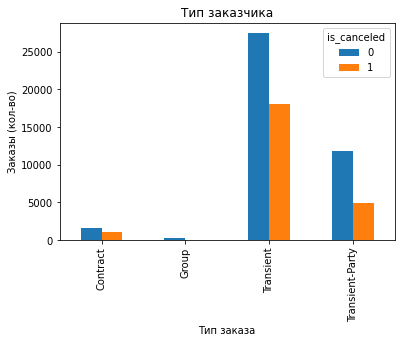

In [36]:
pd.crosstab(df_train['customer_type'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Тип заказчика')
plt.xlabel('Тип заказа')
plt.ylabel('Заказы (кол-во)')

In [37]:
pd.crosstab(df_train['customer_type'], df_train['is_canceled'])

is_canceled,0,1
customer_type,,
Contract,1656,1090
Group,263,24
Transient,27476,18017
Transient-Party,11790,4913


Канал дистрибуции заказа

Text(0, 0.5, 'Заказы (кол-во)')

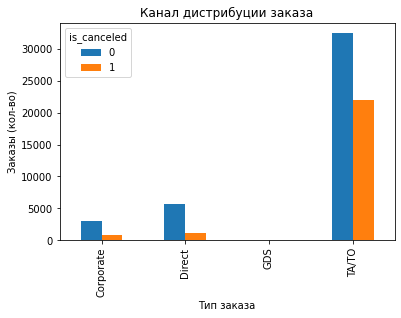

In [38]:
pd.crosstab(df_train['distribution_channel'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Канал дистрибуции заказа')
plt.xlabel('Тип заказа')
plt.ylabel('Заказы (кол-во)')

In [39]:
pd.crosstab(df_train['distribution_channel'], df_train['is_canceled'])

is_canceled,0,1
distribution_channel,,
Corporate,2992,831
Direct,5665,1188
GDS,80,19
TA/TO,32448,22006


`Вывод:` наибольшая пропорция отмены бронирования через канал `TA/TO`

Опции заказа

Text(0, 0.5, 'Заказы (кол-во)')

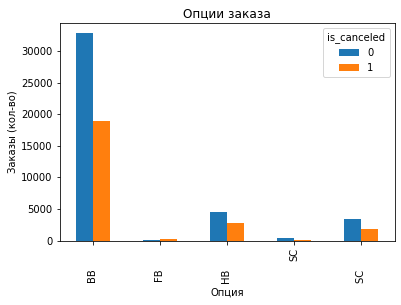

In [40]:
pd.crosstab(df_train['meal'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Опции заказа')
plt.xlabel('Опция')
plt.ylabel('Заказы (кол-во)')

Тип забронированной комнаты

Text(0, 0.5, 'Заказы (кол-во)')

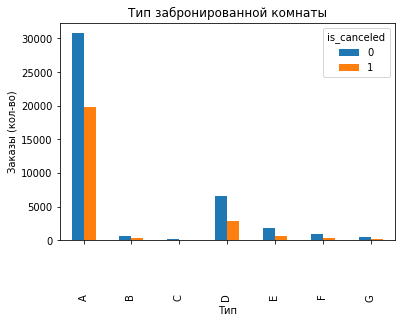

In [41]:
pd.crosstab(df_train['reserved_room_type'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Тип забронированной комнаты')
plt.xlabel('Тип')
plt.ylabel('Заказы (кол-во)')

Количество изменений параметров заказа

Text(0, 0.5, 'Заказы (кол-во)')

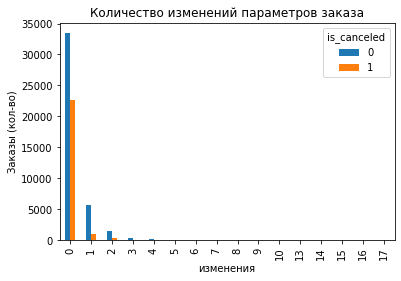

In [42]:
pd.crosstab(df_train['booking_changes'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Количество изменений параметров заказа')
plt.xlabel('изменения')
plt.ylabel('Заказы (кол-во)')

Количество детей от 3 до 14 лет

Text(0, 0.5, 'Заказы (кол-во)')

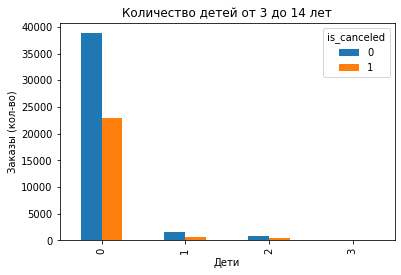

In [43]:
pd.crosstab(df_train['children'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Количество детей от 3 до 14 лет')
plt.xlabel('Дети')
plt.ylabel('Заказы (кол-во)')

Тип заказчика

Text(0, 0.5, 'Заказы (кол-во)')

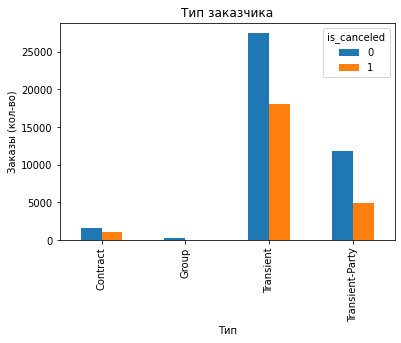

In [44]:
pd.crosstab(df_train['customer_type'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Тип заказчика')
plt.xlabel('Тип')
plt.ylabel('Заказы (кол-во)')

Количество отменённых заказов у клиента

Text(0, 0.5, 'Заказы (кол-во)')

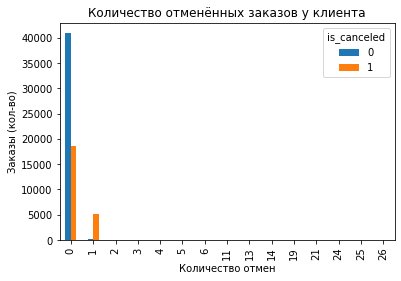

In [45]:
pd.crosstab(df_train['previous_cancellations'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Количество отменённых заказов у клиента')
plt.xlabel('Количество отмен')
plt.ylabel('Заказы (кол-во)')

In [46]:
pd.crosstab(df_train['previous_cancellations'], df_train['is_canceled'])

is_canceled,0,1
previous_cancellations,,
0,40943,18648
1,135,5232
2,31,23
3,35,16
4,4,1
5,11,2
6,0,7
11,25,10
13,1,11


`Вывод:` те кто отменял заказ хотя бы однажды имеют повышенную вероятность отменить новый заказ. То же можно утверждать про тех кто отменял заказы > 13 раз.

Количество специальных отметок

Text(0, 0.5, 'Заказы (кол-во)')

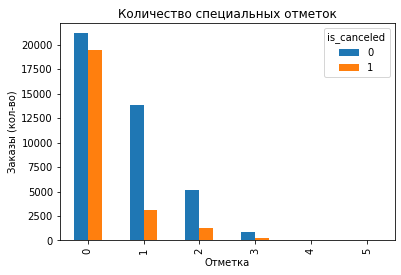

In [47]:
pd.crosstab(df_train['total_of_special_requests'], df_train['is_canceled']).plot(kind = 'bar')
plt.title('Количество специальных отметок')
plt.xlabel('Отметка')
plt.ylabel('Заказы (кол-во)')

In [48]:
pd.crosstab(df_train['total_of_special_requests'], df_train['is_canceled'])

is_canceled,0,1
total_of_special_requests,,
0,21170,19501
1,13884,3074
2,5191,1253
3,833,203
4,94,13
5,13,0


`Вывод:` постояльцы отмеченные специальной меткой `0` имеют более высокие шансы отменить заказ

Проводим анализ баланса классов в целевой переменной

Text(0, 0.5, 'Классы (кол-во)')

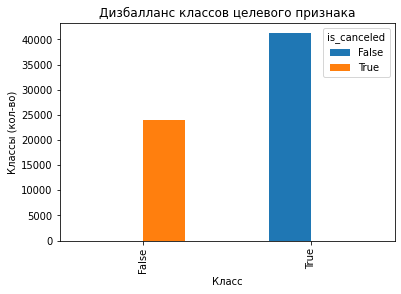

In [49]:
pd.crosstab(df_train['is_canceled'] == 0, df_train['is_canceled'] == 1).plot(kind = 'bar')
plt.title('Дизбалланс классов целевого признака')
plt.xlabel('Класс')
plt.ylabel('Классы (кол-во)')

In [50]:
print('is_canceled = 0: ',df_train.loc[df_train['is_canceled'] == 0, 'is_canceled'].count())
print('is_canceled = 1: ',df_train.loc[df_train['is_canceled'] == 1, 'is_canceled'].count())

is_canceled = 0:  41185
is_canceled = 1:  24044


`Вывод:` Количество отменённых бронирований составляет 58% от количества нетменённых бронирований.

`Вывод ИАД:` Наблюдаются выбросы в количествах дней между датой бронирования и датой прибытия, что не вызывает подозрений те некоторые киенты могли забронировать номер задолго до заезда. Также есть выбивающиеся значения в параметре 'количество специальных отметок', просто отметим этот факт.

Отметим, что наибольшая пропорция отмены бронирования через канал `TA/TO`

Те кто `отменял заказ` хотя бы `однажды` имеют повышенную вероятность отменить новый заказ. То же можно утверждать про тех кто отменял заказы > 13 раз.

Постояльцы отмееные специальной меткой `0` имеют более высокие шансы отменить заказ

### 1.1.4. <a id='toc1_1_4_'></a>[Шаг 3. Формулировка ML-задачи на основе бизнес-задачи](#toc0_)

Создаём функцию для подсчёта прибыли

In [51]:
def profit(row):
    if row['is_canceled'] == 0:
        income = row['winter_night_cost'] * row['season_coeff'] * row['total_nights']
        expences = row['one_time_cleaning_winter'] * round(row['total_nights'] / 2)
    else:
        income = 0
        expences = row['winter_night_cost'] * row['season_coeff'] + row['one_time_cleaning_winter']
    earned = income - expences
    return earned


Создаём новый признак при помощи функции

In [52]:
df_test['profit'] = df_test.apply(profit, axis=1)

Проверяем создание нового признака с прибылью / убытком

In [53]:
# выводим выборочно две колонки

display(df_test.loc[:, ['winter_night_cost', 'profit']])

,winter_night_cost,profit
0,1000,-1400.0
1,1000,-1400.0
2,600,-950.0
3,600,-950.0
4,1000,-1400.0
...,...,...
32407,1000,7200.0
32408,1000,8200.0
32409,1000,8200.0
32410,1000,8200.0


Мы вывели прибыльность каждого объекта в тестовом датафрейме без учёта депозита, чтобы получить общую прибыль: суммируем показания параметра `profit`

In [54]:
# суммарный профит забронированных номеров тестовой выборки
print('Суммарный профит забронированных номеров тестовой выборки:', df_test.loc[(df_test['is_canceled'] == 0)]['profit'].sum())
print()

# суммарный профит отменённых забронированных номеров тестовой выборки
print('Суммарные потери отменённых забронированных номеров тестовой выборки:', df_test.loc[(df_test['is_canceled'] == 1)]['profit'].sum())
print()

# общий суммарный профит тестовой выборки за 8 мес (Январь-Август)
print('Общий суммарный профит тестовой выборки (за 8 мес):', df_test['profit'].sum())
print()

# общий суммарный профит тестовой выборки в пересчёте на год
print('Общий суммарный профит тестовой выборки (за год):', df_test['profit'].sum() * 12/8)

# сохраняем в переменную
profit_before_ml = df_test['profit'].sum() * 12/8

Суммарный профит забронированных номеров тестовой выборки: 58234560.0

Суммарные потери отменённых забронированных номеров тестовой выборки: -17112820.0

Общий суммарный профит тестовой выборки (за 8 мес): 41121740.0

Общий суммарный профит тестовой выборки (за год): 61682610.0


`Вывод:` 29% от вырученых денег это потери связанные с издержками при отмене бронирования (уборка номера + стомость одной ночи)

### 1.1.5. <a id='toc1_1_5_'></a>[Шаг 4. Разработка модели ML](#toc0_)

Делаем преобразование категориальных признаков в цисловые для обучения модели. Прямое кодирование.

In [55]:
display(df_train.head())
df_train.shape

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff
0,0,7,2015,July,1,0,1,1,0,0,BB,Direct,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.4
1,0,14,2015,July,1,0,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,2,1000,400,1.4
2,0,0,2015,July,1,0,2,2,0,0,BB,Direct,0,0,0,C,0,0,Transient,0,0,2,600,350,1.4
3,0,9,2015,July,1,0,2,2,0,0,FB,Direct,0,0,0,C,0,0,Transient,0,1,2,600,350,1.4
4,1,85,2015,July,1,0,3,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,3,1000,400,1.4


(65229, 25)

In [56]:
# преобразуем df_train
df_train_ohe = pd.get_dummies(df_train, drop_first=True)

In [57]:
display(df_train_ohe.head())
df_train_ohe.shape

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7,2015,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1000,400,1.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,14,2015,1,0,2,2,0,0,0,0,0,0,0,0,1,2,1000,400,1.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,2015,1,0,2,2,0,0,0,0,0,0,0,0,0,2,600,350,1.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,0,9,2015,1,0,2,2,0,0,0,0,0,0,0,0,1,2,600,350,1.4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,1,85,2015,1,0,3,2,0,0,0,0,0,0,0,0,1,3,1000,400,1.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


(65229, 47)

In [58]:
display(df_test.head())
df_test.shape

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,profit
0,1,74,2017,January,1,1,0,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.0,-1400.0
1,1,62,2017,January,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.0,-1400.0
2,1,62,2017,January,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,600,350,1.0,-950.0
3,1,71,2017,January,1,2,2,1,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,600,350,1.0,-950.0
4,1,172,2017,January,1,2,5,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.0,-1400.0


(32412, 26)

In [59]:
df_test_ohe = pd.get_dummies(df_test, drop_first=True)

In [60]:
display(df_test_ohe.head())
df_test_ohe.shape

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,profit,arrival_date_month_August,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74,2017,1,1,0,2,0,0,0,0,0,0,0,0,0,1,1000,400,1.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,62,2017,1,2,2,2,0,0,0,0,0,0,0,0,1,4,1000,400,1.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,62,2017,1,2,2,2,0,0,0,0,0,0,0,0,1,4,600,350,1.0,-950.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,71,2017,1,2,2,1,0,0,0,0,0,0,0,0,1,4,600,350,1.0,-950.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,172,2017,1,2,5,2,0,0,0,0,0,0,0,0,0,7,1000,400,1.0,-1400.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


(32412, 44)

Проверяем разницу в параметрах между датасетами после кодировки

In [61]:
# мы видим что пять параметров отсутствуют в обеих датасетах одновременно

df_test_ohe.columns ^ df_train_ohe.columns

/tmp/ipykernel_571/860116454.py:3: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead
  df_test_ohe.columns ^ df_train_ohe.columns


Index(['arrival_date_month_December', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September', 'profit'],
      dtype='object')

Добавляем недостающие параметры в кодированные датасеты:

четыре параметра добавляем в `df_test_ohe`
один параметр в `df_train_ohe`

In [62]:
# df_test_ohe
df_test_ohe.insert(22, 'arrival_date_month_December', 0)
df_test_ohe.insert(29, 'arrival_date_month_November', 0)
df_test_ohe.insert(30, 'arrival_date_month_October', 0)
df_test_ohe.insert(31, 'arrival_date_month_September', 0)

# df_train_ohe
df_train_ohe.insert(20, 'profit', 0)

In [63]:
display(df_test_ohe.head())
df_test_ohe.shape

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,profit,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74,2017,1,1,0,2,0,0,0,0,0,0,0,0,0,1,1000,400,1.0,-1400.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,62,2017,1,2,2,2,0,0,0,0,0,0,0,0,1,4,1000,400,1.0,-1400.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,62,2017,1,2,2,2,0,0,0,0,0,0,0,0,1,4,600,350,1.0,-950.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,71,2017,1,2,2,1,0,0,0,0,0,0,0,0,1,4,600,350,1.0,-950.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,172,2017,1,2,5,2,0,0,0,0,0,0,0,0,0,7,1000,400,1.0,-1400.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


(32412, 48)

In [64]:
display(df_train_ohe.head())
df_train_ohe.shape

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,profit,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7,2015,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1000,400,1.4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,0,14,2015,1,0,2,2,0,0,0,0,0,0,0,0,1,2,1000,400,1.4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,2015,1,0,2,2,0,0,0,0,0,0,0,0,0,2,600,350,1.4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,0,9,2015,1,0,2,2,0,0,0,0,0,0,0,0,1,2,600,350,1.4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,1,85,2015,1,0,3,2,0,0,0,0,0,0,0,0,1,3,1000,400,1.4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


(65229, 48)

Проеверяем что нет колонок присутствующих только в одном датафрейме

In [65]:
df_test_ohe.columns ^ df_train_ohe.columns

/tmp/ipykernel_571/652679777.py:1: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead
  df_test_ohe.columns ^ df_train_ohe.columns


Index([], dtype='object')

Параметры в обоих датафреймах совпадают. Приступаем к разделению на целевую и нецелевые выбрки для тренировочного `df_train` и тестового датафрейма `df_test`

Делим тренировочную и валидационную выборки на целевые и нецелевые выборки

In [66]:
# извлекаем признаки, исключаем целевой признак и признаки которые не имеет предсказательной силы 
features_train = df_train_ohe.drop(['is_canceled'], axis=1) 
    
# извлекаем целевой признак
target_train = df_train_ohe['is_canceled'] 

# извлекаем признаки, исключаем целевой признак и признаки которые не имеет предсказательной силы 
features_test = df_test_ohe.drop(['is_canceled'], axis=1)
    
# извлекаем целевой признак
target_test = df_test_ohe['is_canceled'] 

Выводим размеры полученых выборок

In [67]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(65229, 47)
(65229,)
(32412, 47)
(32412,)


Проводим масштабирование 

In [68]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

pd.options.mode.chained_assignment = None


`Выбор метрики для моделей:` самой важной метрикой для задачи является `полнота (Recall)` тк эта метрика определяет количество истинно положительных среди всех меток класса, которые были определены как «положительный». Эта оценочная метрика особенно важна когда в поставленной задаче ошибка нераспознания положительного класса высока. В нашем случае, нераспознание положительного класса приведёт неверной к оценке отказавшихся от бронирования постояльцев и как результат неверный прогноз отказников. Это приведёт к непредвиденным убыткам.

Logistic Regression

In [69]:
# инициализация модели
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=2000)
# обучение модели
model.fit(features_train, target_train)

# предсказания модели
predictions_logistic = model.predict(features_train)

probabilities_valid = model.predict_proba(features_train)
probabilities_one_valid = probabilities_valid[:, 1]

# кроссвалидация с пятью блоками
mean_score = cross_val_score(model, features_train, target_train, cv=5, scoring='recall').mean()

# Вывод метрики Полноты
print('Лучшая полнота              ', mean_score)




Лучшая полнота               0.30983093264189543


Decision Tree

In [70]:
# создаём переменные для выявления лучшей модели и лучшего результата
best_model = None
best_mean_score = 0
best_criterion = 0


creteria_list = ['gini', 'entropy']
# создаём цикл для перебора гиперпараметра criterion
for crit in creteria_list:
	# создаём цикл для перебора глубины дерева
	for depth in range(1, 20):
		# создам переменную и записываем в неё модель с перебором глубины деревьев и добавлением случайности для улучшения результата
		model = DecisionTreeClassifier(criterion=crit, random_state=12345, max_depth= depth)

		# обучаем модель с заданной глубиной дерева
		model.fit(features_train, target_train)

		# высчитываем предсказания модели на основе валидационной выборки
		predictions_dt = model.predict(features_train)
		probabilities_valid = model.predict_proba(features_train)
		probabilities_one_valid = probabilities_valid[:, 1]
		
	
		mean_score = cross_val_score(model, features_train, target_train, cv=5, scoring='recall').mean()
		
		# находим лучшую модель
		if mean_score > best_mean_score:
			best_criterion = crit
			best_mean_score = mean_score
			best_model = model
			
		
		
# выдод результатов классификации    
print('Лучшая модель:                           ', best_model)
print('Лучший критерий:                         ', best_criterion)
print('Лучшая полнота:                          ', best_mean_score)



Лучшая модель:                            DecisionTreeClassifier(max_depth=4, random_state=12345)
Лучший критерий:                          gini
Лучшая полнота:                           0.636303974902853


Random Forest

In [71]:
# создаём переменные для выявления лучшей модели, лучшего результата
# создаём счётчики кол-ва деревьев и глубины деревьев чтобы выявить сочетание с лучшим показателем accuracy
best_model = None
n_est = 0
max_depth = 0
best_recall = 0
best_final_score = 0


# создаём цикл с перебором по кол-ву деревьев
for est in range(40, 50):
    # создаём вложенный цикл с перебором глубины каждого дерева
    for depth in range(1, 10):

        # создам переменную и записываем в неё модель с перебором кол-ва деревьев, 
        # глубины деревьев и добавлением случайности для улучшения результата
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)

        # обучаем модель на тренировочной выборке
        model.fit(features_train, target_train)

        # высчитываем предсказания модели на основе тренировочной выборки
        predictions = model.predict(features_train)

        
        # проводим кросс-валидацию
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='recall')
        final_score = scores.mean()

        probabilities_valid = model.predict_proba(features_train)
        probabilities_one_valid = probabilities_valid[:, 1]


        # находим лучшую модель, находим оптимальное кол-во деревьев и их глубину
        if final_score > best_final_score:
            best_final_score = final_score
            n_est = est
            max_depth = depth
            best_model = model
        

# выдод результатов классификации случайного леса

print('Количество деревьев (est):                       ', n_est) 
print('Глубина дерева (depth):                          ', max_depth)
print('Лучшая полнота:                                  ', best_final_score)



Количество деревьев (est):                        47
Глубина дерева (depth):                           9
Лучшая полнота:                                   0.3952128375491184


`Вывод:` 

По результатам обучения моделей, лучшей моделью с самыми высокими метриками полноты оказалось `Дерево решений`.

#### 1.1.5.1. <a id='toc1_1_5_1_'></a>[Применение лучшей модели на тестовой выборке](#toc0_)

Применяем дерево решений для `df_test` выборки с наилучшими параметрами: `DecisionTreeClassifier(max_depth=19, random_state=12345)` criterion='gini'

In [72]:
# создам переменную и записываем в неё модель с лучшими показателями пртестированными на тренировочной выборке.
model = DecisionTreeClassifier(criterion='gini', random_state=12345, max_depth= 4) 

# обучаем модель с заданной глубиной дерева
model.fit(features_train, target_train)

# высчитываем предсказания модели на основе валидационной выборки
predictions_dt_test = model.predict(features_test)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# находим качество модели сравнивая результаты валидационой выборки и результаты предсказательной модели
result = accuracy_score(target_test, predictions_dt_test)

# сохраняем значения метрик в переменные
f1 = f1_score(target_test, predictions_dt_test)
recall = recall_score(target_test, predictions_dt_test)
roc = roc_auc_score(target_test, probabilities_one_test)

		
# выдод результатов классификации    
   
print('Лучшая (Accuracy):                         ', result)
print('Лучшая F1-мера:                            ', f1)
print('Лучшая полнота:                            ', recall)
print('Лучшая ROC_AUC:                            ', roc)
 


Лучшая (Accuracy):                          0.7234357645316549
Лучшая F1-мера:                             0.6163984936665525
Лучшая полнота:                             0.5719958700659201
Лучшая ROC_AUC:                             0.7378422634304449


Проверяем тип предсказаний и меняем на Series для того чтобы добавить предсказания в таблицу `df_test`

In [73]:
# проверяем тип данных
print(type(predictions_dt_test))

# меняем тип данных
predictions_dt_test_series = pd.Series(predictions_dt_test)

# проверяем смену типа на Series
type(predictions_dt_test_series)


<class 'numpy.ndarray'>


pandas.core.series.Series

Добавляем в `df_test` новый параметр `is_canceled_predicted` с предсказаниями модели.

In [74]:
df_test['is_canceled_predicted'] = predictions_dt_test_series

Выводим таблицу для просмотра

In [75]:
df_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,profit,is_canceled_predicted
0,1,74,2017,January,1,1,0,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1000,400,1.0,-1400.0,1
1,1,62,2017,January,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1000,400,1.0,-1400.0,0
2,1,62,2017,January,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,600,350,1.0,-950.0,0
3,1,71,2017,January,1,2,2,1,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,600,350,1.0,-950.0,0
4,1,172,2017,January,1,2,5,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1000,400,1.0,-1400.0,1


Подсчёт прибыли

In [76]:
def profit_predicted(row, col):
    if row['is_canceled'] == 0:
        income = row['winter_night_cost'] * row['season_coeff'] * row['total_nights']
        expences = row['one_time_cleaning_winter'] * round(1 + row['total_nights'] // 2)
    elif(row[col] == 0) and (row['is_canceled'] ==1 ):
        income = 0 #бронь отменена, прибыль отсутствует
        expences = row['one_time_cleaning_winter'] + row['winter_night_cost'] * row['season_coeff']
        
    elif (row[col] == 1) and (row['is_canceled']==1):
        # вариант 3 если система верно предсказала отмену брони, то клиенту предлагается депозит,
        income= row['winter_night_cost'] * 0.8 * row['season_coeff'] + row['one_time_cleaning_winter'] * 0.8
        # а в расход идет только разовое обслуживание
        expences = row['one_time_cleaning_winter'] + row['winter_night_cost'] * row['season_coeff']
    profit_total = income - expences
    return profit_total

In [77]:
df_test['profit_predicted'] = df_test.apply(profit_predicted, col='is_canceled_predicted', axis = 1)
profit_predicted2 = df_test['profit_predicted'].sum()

print('Суммарный профит тестовой выборки (за год) до прогнозирования:                ',  profit_before_ml)
#print()
print('Суммарный профит тестовой выборки после ML (за 8 мес):                        ',  profit_predicted2)
#print()
print('Суммарный профит тестовой выборки после ML (за год):                          ',  profit_predicted2 * 12/8)
#print()
print('Суммарный профит тестовой выборки (за год) после ML с учётом бюджета 400к:    ',  profit_predicted2 * 12/8 - BUDGET)
#print()
print('Выигрыш от внедрения модели (за год) с учётом  бюджета 400к:                  ',  (profit_predicted2 * 12/8 - profit_before_ml) - BUDGET)


Суммарный профит тестовой выборки (за год) до прогнозирования:                 61682610.0
Суммарный профит тестовой выборки после ML (за 8 мес):                         44049248.0
Суммарный профит тестовой выборки после ML (за год):                           66073872.0
Суммарный профит тестовой выборки (за год) после ML с учётом бюджета 400к:     65673872.0
Выигрыш от внедрения модели (за год) с учётом  бюджета 400к:                   3991262.0


`Вывод:` В результате применения модели `дерево решений` нам удалось получить предсказания отказа от бронирования клиентов, что повысило прогностическую способность и привело к повышению прибыли отеля с 61682610.0 руб. до 65673872.0 руб. с учётом затраченного бюджета 400 000 на создание модели.

В итоге, с учётом затрат на создание модели, прибыль отеля выросла после применения модели выросла на 3991262.0 руб.

### 1.1.6. <a id='toc1_1_6_'></a>[Шаг 5. Опишите портрет «ненадёжного» клиента](#toc0_)

Создаём список признаков для определения их влияния на целевой признак

In [78]:
df_test_ohe_col = df_test_ohe.columns
df_test_ohe_col = df_test_ohe_col.drop(['profit'])
df_test_ohe_col

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'winter_night_cost',
       'one_time_cleaning_winter', 'season_coeff', 'arrival_date_month_August',
       'arrival_date_month_December', 'arrival_date_month_February',
       'arrival_date_month_January', 'arrival_date_month_July',
       'arrival_date_month_June', 'arrival_date_month_March',
       'arrival_date_month_May', 'arrival_date_month_November',
       'arrival_date_month_October', 'arrival_date_month_September',
       'meal_FB       ', 'meal_HB       ', 'meal_SC', 'meal_SC       ',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_ch

Вычисляем и визуализализируем `feature importance` для тестового датасета

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,winter_night_cost,one_time_cleaning_winter,season_coeff,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,meal_SC,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74,2017,1,1,0,2,0,0,0,0,0,0,0,0,0,1,1000,400,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,1,62,2017,1,2,2,2,0,0,0,0,0,0,0,0,1,4,1000,400,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,62,2017,1,2,2,2,0,0,0,0,0,0,0,0,1,4,600,350,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,71,2017,1,2,2,1,0,0,0,0,0,0,0,0,1,4,600,350,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,172,2017,1,2,5,2,0,0,0,0,0,0,0,0,0,7,1000,400,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


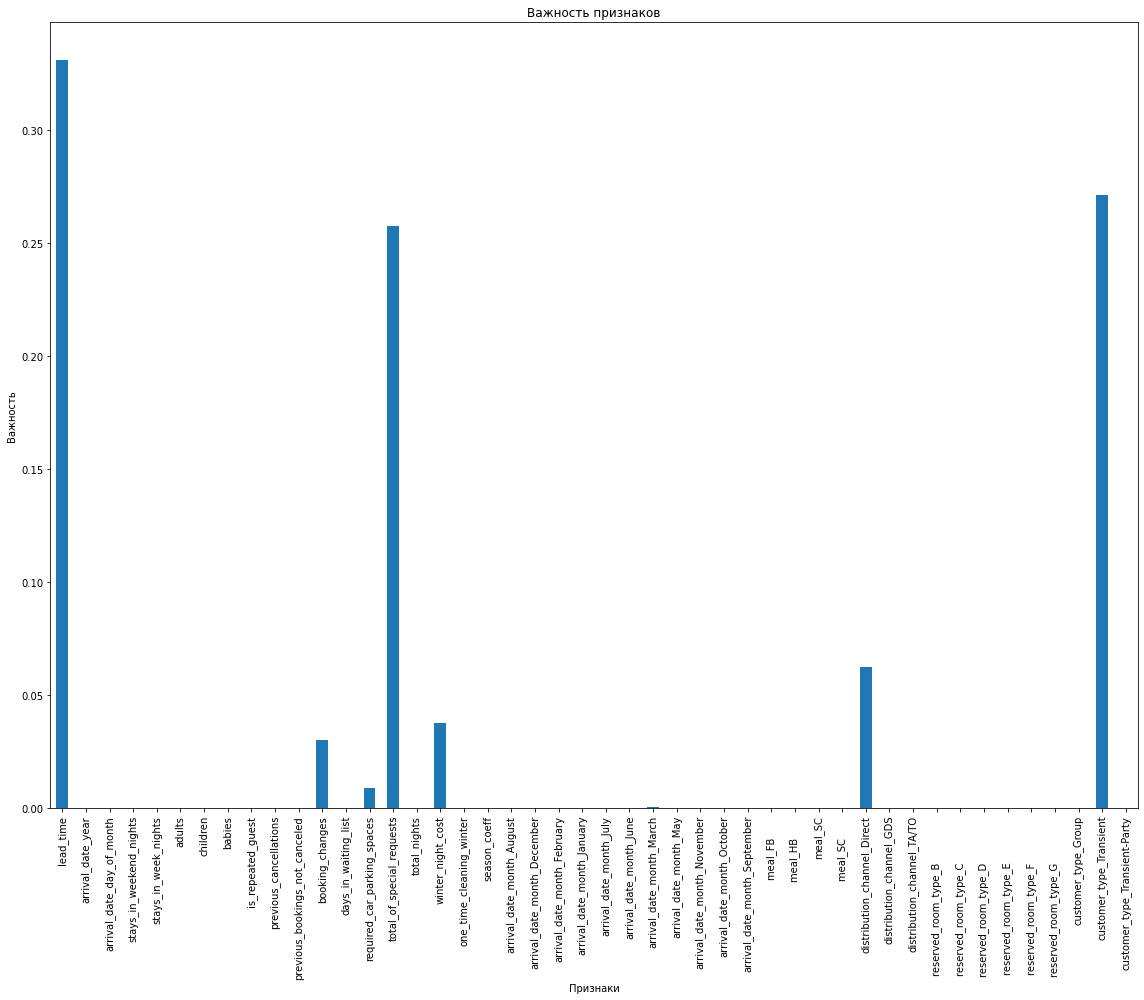

In [79]:
df_test_v = pd.DataFrame(data=df_test_ohe, columns=df_test_ohe_col)
df_test_v['is_canceled'] = df_test_ohe['is_canceled']
display(df_test_v.head())

model = DecisionTreeClassifier(random_state=12345, max_depth = 4)
model.fit(X = df_test_v.drop(['is_canceled'], axis=1),
y = df_test_v['is_canceled'])

df_test_imp = pd.Series(model.feature_importances_, df_test_v.drop(['is_canceled'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))

df_test_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность')
fig.tight_layout()

`Вывод:` наибольшее влиеяние в порядке убывания, оказали параметры: 

*lead_time* 

*customer_type_Transient* 

*total_of_special_requests* 

Посмотрим, как именно эти значения оказывают влияние на отказ от бронирования.

**Проверяем `lead_time`**

In [80]:
# создаём список вместо array
lead_time_list = df_test_ohe['lead_time'].unique()
lead_time_list = pd.Series(lead_time_list)

Проходимся циклом по всем значения `lead_time` чтобы понять при каких его значениях наблюдается наибольшее количество отмен

In [81]:
most_cancellations = 0
best_lt = 0

for i in lead_time_list:
    cancellations = df_test_ohe.loc[(df_test_ohe['lead_time'] == i) & (df_test_ohe['is_canceled'] == 1), 'is_canceled'].count()
    
    if cancellations > most_cancellations:
        most_cancellations = cancellations
        best_lt = i
print('Большинство отмен:                     ', most_cancellations)
print('Наблюдается для  "Lead time в днях":   ', best_lt)

Большинство отмен:                      177
Наблюдается для  "Lead time в днях":    56


Создаём график для наглядности

Text(0, 0.5, 'Статус отмены (1 - отмена, 0 - нет отмены')

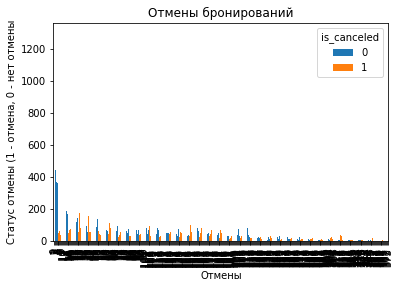

In [82]:
pd.crosstab(df_test_ohe['lead_time'], df_test_ohe['is_canceled']).plot(kind = 'bar')
plt.title('Отмены бронирований')
plt.xlabel('Отмены')
plt.ylabel('Статус отмены (1 - отмена, 0 - нет отмены')

`Вывод:` Большинство отмен наблюдаются для отметки 56 дней между датой бронирования и датой прибытия

**Проверяем `total_of_special_requests`**

In [83]:
# уникальные значения
df_test_ohe['total_of_special_requests'].unique()

array([0, 1, 2, 3, 4, 5])

In [84]:
# находим количество отмен для значения ['total_of_special_requests'] == 0
df_test_ohe.loc[(df_test_ohe['total_of_special_requests'] == 0) & (df_test_ohe['is_canceled'] == 1), 'is_canceled'].count()

8575

Создаём график для наглядности

Text(0, 0.5, 'Статус отмены (1 - отмена, 0 - нет отмены')

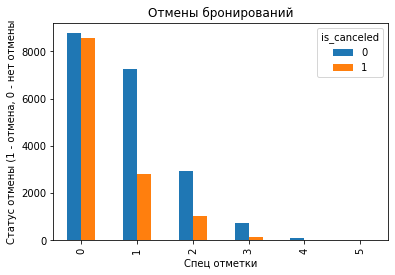

In [85]:
pd.crosstab(df_test_ohe['total_of_special_requests'], df_test_ohe['is_canceled']).plot(kind = 'bar')
plt.title('Отмены бронирований')
plt.xlabel('Спец отметки')
plt.ylabel('Статус отмены (1 - отмена, 0 - нет отмены')

`Вывод:` Большинство отмен наблюдаются для спец-отметки - 0.

**Проверяем `customer_type_Transient`**

In [86]:
# уникальные значения
df_test_ohe['customer_type_Transient'].unique()

array([1, 0], dtype=uint8)

In [87]:
# находим количество отмен для значения ['customer_type_Transient'] == 1
df_test_ohe.loc[(df_test_ohe['customer_type_Transient'] == 1) & (df_test_ohe['is_canceled'] == 1), 'is_canceled'].count()

11805

Создаём график для наглядности

Text(0, 0.5, 'Статус отмены (1 - отмена, 0 - нет отмены')

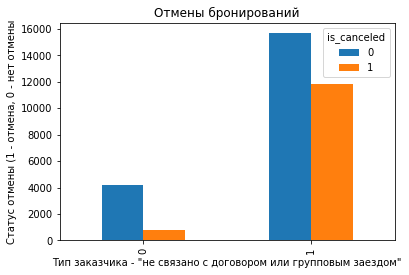

In [88]:
pd.crosstab(df_test_ohe['customer_type_Transient'], df_test_ohe['is_canceled']).plot(kind = 'bar')
plt.title('Отмены бронирований')
plt.xlabel('Тип заказчика - "не связано с договором или групповым заездом"')
plt.ylabel('Статус отмены (1 - отмена, 0 - нет отмены')

`Вывод:` Большинство отмен наблюдаются для типа заказчика - "не связано с договором или групповым заездом"

`Общий вывод, портрет ненадёжного клиента:`

По результатам предсказаний модели, самое большое влияние, с большим отрываом, на целевой признак (отказ от бронирования) оказало `lead_time` — количество дней между датой бронирования и датой. 

На втором месте идёт день месяца - `customer_type_Transient` — тип заказчика. и с небольшим отвывом `total_of_special_requests` — количество специальных отметок.

Портрет ненадёжного клиента склонного к отмене бронирования номера:

- Клиент у которого между датой бронирования и датой прибытия прошло 56 дней 
- Клиенты со спец-отметкой - 0.
- Клиенты относящиеся к типу заказчика - "не связано с договором или групповым заездом"

### 1.1.7. <a id='toc1_1_7_'></a>[Шаг 6. Напишите общий вывод](#toc0_)

**Резюме:**

В результате проведённого исследования, наилучшей моделью для предсказания отмены бронирования окакзалась модель Дерева решений тк показала лучшую метрику полноты которая является ключевой в данной задаче.

Самой важной метрикой для задачи является `полнота (Recall)` тк эта метрика определяет количество истинно положительных среди всех меток класса, которые были определены как «положительный». Эта оценочная метрика особенно важна когда в поставленной задаче ошибка нераспознания положительного класса высока. В нашем случае, нераспознание положительного класса приведёт неверной к оценке отказавшихся от бронирования постояльцев и как результат неверный прогноз отказников. Это приведёт к непредвиденным убыткам.

В нашем кейсе наибольшую эффективность и точность показала модель:

`DecisionTreeClassifier(max_depth=19, random_state=12345)`


**Рекомендации:**

При выборе потенциальных постояльцев с которых стоит брать депозитную предоплату считаю целесообразным обратить внимание на следущие категории постояльцев:


По результатам предсказаний модели, самое большое влияние, с большим отрываом, на целевой признак (отказ от бронирования) оказало `lead_time` — количество дней между датой бронирования и датой. 

На втором месте идёт день месяца - `customer_type_Transient` — тип заказчика и с небольшим отвывом `total_of_special_requests` — количество специальных отметок.

Следует избегать клиентов близких к портрету ненедёжного клиента, которым является следующий набор характеристик:


- Клиент у которого между датой бронирования и датой прибытия прошло 56 дней 
- Клиенты со спец-отметкой - 0.
- Клиенты относящиеся к типу заказчика - "не связано с договором или групповым заездом"